# 11. Simple CNN

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn.init
from torch.autograd import Variable

import torchvision
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.utils.data as Data

import numpy as np
import random
import os

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## 11.1 Prepare Custom Data

In [3]:
img_dir = "./data/jamo"
img_data = dsets.ImageFolder(img_dir, transforms.Compose([
            transforms.Grayscale(),
            transforms.ToTensor(),
            ]))

#https://pytorch.org/docs/stable/torchvision/transforms.html

print(img_data.classes)
print(img_data.class_to_idx)

['ㄱ', 'ㄲ', 'ㄴ', 'ㄷ', 'ㄸ', 'ㄹ', 'ㅁ', 'ㅂ', 'ㅃ', 'ㅅ', 'ㅆ', 'ㅇ', 'ㅈ', 'ㅉ', 'ㅊ', 'ㅋ', 'ㅌ', 'ㅍ', 'ㅎ', 'ㅏ', 'ㅐ', 'ㅑ', 'ㅒ', 'ㅓ', 'ㅔ', 'ㅕ', 'ㅖ', 'ㅗ', 'ㅘ', 'ㅙ', 'ㅛ', 'ㅜ', 'ㅝ', 'ㅞ', 'ㅟ', 'ㅠ', 'ㅡ', 'ㅢ', 'ㅣ']
{'ㄱ': 0, 'ㄲ': 1, 'ㄴ': 2, 'ㄷ': 3, 'ㄸ': 4, 'ㄹ': 5, 'ㅁ': 6, 'ㅂ': 7, 'ㅃ': 8, 'ㅅ': 9, 'ㅆ': 10, 'ㅇ': 11, 'ㅈ': 12, 'ㅉ': 13, 'ㅊ': 14, 'ㅋ': 15, 'ㅌ': 16, 'ㅍ': 17, 'ㅎ': 18, 'ㅏ': 19, 'ㅐ': 20, 'ㅑ': 21, 'ㅒ': 22, 'ㅓ': 23, 'ㅔ': 24, 'ㅕ': 25, 'ㅖ': 26, 'ㅗ': 27, 'ㅘ': 28, 'ㅙ': 29, 'ㅛ': 30, 'ㅜ': 31, 'ㅝ': 32, 'ㅞ': 33, 'ㅟ': 34, 'ㅠ': 35, 'ㅡ': 36, 'ㅢ': 37, 'ㅣ': 38}


In [4]:
batch_size = 100
font_num = 720

In [5]:
def train_test_split(data, train_ratio, stratify, stratify_num, batch_size) :
    
    length = len(data)
    
    if stratify :
        label_num = int(len(data)/stratify_num)
        cut = int(stratify_num*train_ratio)
        train_indices = np.random.permutation(np.arange(stratify_num))[:cut]
        test_indices = np.random.permutation(np.arange(stratify_num))[cut:]    
        
        for i in range(1, label_num) :
            train_indices = np.concatenate((train_indices, np.random.permutation(np.arange(stratify_num))[:cut] + stratify_num*i))
            test_indices = np.concatenate((test_indices, np.random.permutation(np.arange(stratify_num))[cut:] + stratify_num*i))
        
    else :
        cut = int(len(data)*train_ratio)
        train_indices = np.random.shuffle(np.random.permutation(np.arange(length))[:cut])
        test_indices = np.random.shuffle(np.random.permutation(np.arange(length))[cut:])
    
    np.random.shuffle(test_indices)
    np.random.shuffle(train_indices)
    
    train_loader = Data.DataLoader(data, batch_size=batch_size, shuffle=False, sampler = train_indices, num_workers=1, drop_last = True)
    test_loader = Data.DataLoader(data, batch_size=batch_size, shuffle=False, sampler = test_indices, num_workers=1, drop_last = True)

    return train_loader, test_loader, len(train_indices), len(test_indices)

In [6]:
train_loader, test_loader, train_num, test_num = train_test_split(img_data, 0.8, True, font_num, batch_size)

In [7]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

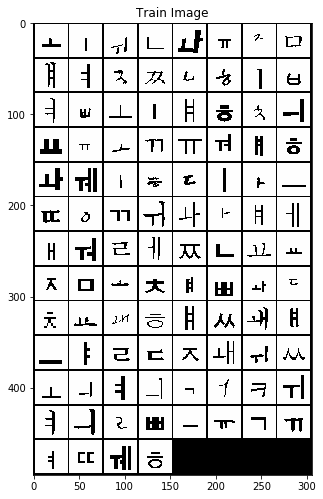

In [8]:
images, labels = iter(train_loader).next()
imshow(torchvision.utils.make_grid(images, normalize=True), "Train Image")

In [9]:
images.shape, labels[0:5]

(torch.Size([100, 1, 36, 36]), 
  27
  38
  34
   2
  28
 [torch.LongTensor of size 5])

## 11.2 Define Model

In [16]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.layer = nn.Sequential(
            nn.Conv2d(1,16,5), # 16 * 32 * 32
            nn.ReLU(),
            nn.Conv2d(16,32,5), # 32 * 28 * 28
            nn.ReLU(),
            nn.MaxPool2d(2,2) # 32 * 14 * 14
        )
        
        self.fc_layer = nn.Sequential(
            nn.Linear(32*14*14,39)
        ) 
        
    def forward(self,x):
        out = self.layer(x)
        out = out.view(batch_size,-1)
        out = self.fc_layer(out)

        return out

In [17]:
model = CNN().cuda()

In [18]:
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

## 11.3 Train Model

In [19]:
num_epochs = 5

In [20]:
for epoch in range(num_epochs):

    for i, (batch_images, batch_labels) in enumerate(train_loader):

        X = Variable(batch_images).cuda()
        Y = Variable(batch_labels).cuda()

        pre = model(X)
        cost = loss(pre, Y)

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print('Epoch [%d/%d], lter [%d/%d], Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, train_num//batch_size, cost.data[0]))

Epoch [1/5], lter [100/224], Loss: 0.8950
Epoch [1/5], lter [200/224], Loss: 0.6248
Epoch [2/5], lter [100/224], Loss: 0.4641
Epoch [2/5], lter [200/224], Loss: 0.2684
Epoch [3/5], lter [100/224], Loss: 0.3361
Epoch [3/5], lter [200/224], Loss: 0.1162
Epoch [4/5], lter [100/224], Loss: 0.2420
Epoch [4/5], lter [200/224], Loss: 0.0733
Epoch [5/5], lter [100/224], Loss: 0.1793
Epoch [5/5], lter [200/224], Loss: 0.0460


## 11.4 Test Model

In [21]:
model.eval()

correct = 0
total = 0

for images, labels in test_loader:
    
    images = Variable(images).cuda()
    outputs = model(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels.cuda()).sum()
    
print('Accuracy of test images: %f %%' % (100 * correct / total))

Accuracy of test images: 96.392857 %
